# Continous Control
## Solving the reacher environment using a PPO agent

### Import and set environment


In [18]:
from unityagents import UnityEnvironment

import numpy as np
import random
import tqdm
import sys
from collections import namedtuple, deque

import torch
import torch.nn as nn # neural networks 
import torch.optim as optim
import torch.nn.functional as F


from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import warnings; warnings.simplefilter('ignore')


### Configuration parameters

In [2]:
# set params
## from https://medium.com/aureliantactics/ppo-hyperparameters-and-ranges-6fc2d29bccbe
## from 
SEED = 1 # replicability randomization seed
np.random.seed(SEED)
torch.random.manual_seed(SEED)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GAMMA = 0.99 #discount factor
GAE_LAMBDA = 0.95 # Generalized Advantage Estimation paramter
GRAD_CLIP = 5 # !!!!!!!!!!!!
PPO_CLIP = 0.2 # PPO clip parameter
ENTROPY_COEFF = 0.01 # a regularizer
VF_COEFF = 0.5 # value function Coefficient 

ALPHA = 3e-4 #learning rate
ADAM_EPS = 1e-5 # optimizer improve numerical stability 

ROLLOUT_LEN = 2048 #size of rollout
N_EPOCHS = 10 # update policy for K epochs
LOG_INT = 2048

MAX_TS = 1e5 # max timesteps in one episode #max_timesteps
MAX_EPISODES = 250 # max training # max_episodes
MINIBATCH_SIZE = 32 # training batched

HIDDEN_LAYER_N = 512 # hidden layer size

BENCHMARK = 30 # agent goal reward

### Build the actor critic network

In [3]:
class NN (nn.Module):
    '''
    a general neural network
    '''
    def __init__(self, state_size, 
                       action_size, 
                       hidden_size, 
                       output_activation=None):
        
        super(NN, self).__init__()
        
        self.layer1 = nn.Linear(state_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, action_size)
        self.output_activation = output_activation

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        
        if self.output_activation:
            x = self.output_activation(x)
        return x
    

class ActorCritic(nn.Module):
    '''
    A simple AC agent for the 
    PPO's policy network and evalutaion network 
    '''
    def __init__(self, 
                 state_size, action_size, 
                 hidden_size=HIDDEN_LAYER_N, 
                 device=DEVICE):
        
        super(ActorCritic, self).__init__()
        
        
        #an Actor: controls how our agent behaves (policy-based)
        self.actor =  NN(state_size, action_size, 
                             hidden_size, F.tanh)
        
        #a Critic: measures how good the action taken is (value-based)
        self.critic =  NN(state_size, 1, hidden_size)

        self.action_var = nn.Parameter(torch.ones(1, action_size))
        self.to(device)

    def forward(self, observations, action=None):
        #get observations, action, and state
        observations = torch.Tensor(observations)
        actor_action = self.actor(observations)
        critic_value = self.critic(observations)
        
        #if no action yet, sample from actor's netowrk
        N_dist = torch.distributions.Normal(actor_action, self.action_var)
        if action is None:
            action = N_dist.sample()
        
        #calc action log prob
        log_prob = N_dist.log_prob(action)
        log_prob = torch.sum(log_prob, dim=1, keepdim=True)
        
        tensor_log_prob = torch.Tensor(np.zeros((log_prob.size(0), 1)))
        
        return action, log_prob, tensor_log_prob, critic_value
            
    

### set a buffer and a rollout

In [4]:
class Buffer:
    '''
    The class generates shuffles batch indexes for batch training
    '''
    def __init__(self, 
                 states_0,
                 batch_size=MINIBATCH_SIZE):
        
        self.batch_size = states_0//batch_size
        self.data = [np.arange(states_0)]
        self.N_elements = len(self.data[0]) #data element size
        
        self.clear()

    def clear(self):
        '''clear the buffer'''
        self.batch_start = 0
        self.batch_end = self.batch_start + self.batch_size
        
    def end(self):
        '''end if reached the end of the buffer'''
        return self.batch_start >= self.N_elements

    def get_next_batch(self):
        '''get a minibatch for updating'''
        
        batch_ind = []
        # load observations from memory into buffer in chunks
        for i in self.data:
            batch_ind.append(i[self.batch_start: 
                                     self.batch_end])
        #move indices
        self.batch_start = self.batch_end
        self.batch_end = min(self.batch_start + self.batch_size, 
                             self.N_elements)
        return batch_ind

    def shuffle(self):
        '''shuffle memory'''
        indexes = np.arange(self.N_elements)
        np.random.shuffle(indexes)
        self.data = [i[indexes] for i in self.data]


In [5]:
class Rollout():
    '''
    Monte Carlo simulations for observations sampling
    '''
    def __init__(self, 
                 n_agents,
                 gamma=GAMMA, 
                 gae_lambda=GAE_LAMBDA):
        
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.n_agents = n_agents
        self.start()

    def start(self):
        ''' init arrays for all observations'''
        self.states = []
        self.state_values = []
        self.actions = []
        self.action_log_probs = []
        self.rewards = []
        self.dones = []

    def __len__(self):
        return len(self.states)

    def record_obs(self, state, 
                         state_value, 
                         action, 
                         action_log_prob):
        
        ''' record policy decision'''
        self.states.append(state)
        self.state_values.append(state_value)
        self.actions.append(action)
        self.action_log_probs.append(action_log_prob)

    def record_reward(self, reward, done):
        ''' record outcome'''
        self.rewards.append(reward)
        self.dones.append(done)

    def get_trajectories(self):
        ''' '''
        N = self.__len__()
        rollout = [None] * (N - 1)
        advantages = torch.Tensor(np.zeros((self.n_agents, 1)))
        returns = self.state_values[-1].detach()
        
        for i in reversed(range(N - 1)): 
            
            states = torch.Tensor(self.states[i])
            values = self.state_values[i]
            actions = torch.Tensor(self.actions[i])
            log_probs = self.action_log_probs[i]
            rewards = torch.Tensor(self.rewards[i]).unsqueeze(1)
            dones = torch.Tensor(self.dones[i]).unsqueeze(1)
            
            next_values = self.state_values[i+1]
            returns = rewards + self.gamma * dones * returns
            
            #calc td error & advantages
            td_error = rewards + self.gamma * dones *\
                        next_values.detach() - values.detach()
            advantages = advantages * self.gae_lambda *\
                            self.gamma * dones + td_error
            
            rollout[i] = [states, actions, log_probs, returns, advantages]

        states, actions, log_probs_old, returns, advantages =\
            map(lambda x: torch.cat(x, dim=0), zip(*rollout))
        
        # normalize advantages
        norm_advantages = (advantages - advantages.mean())\
                                    / advantages.std()
        
        return states, actions, log_probs_old, returns, norm_advantages
        
        
 
        
   
            

### PPO agent

In [6]:
class PPO:
    
    def __init__(self, 
                 env,
                 minibatch = MINIBATCH_SIZE,
                 lr = ALPHA, 
                 eps = ADAM_EPS,
                 gamma = GAMMA, 
                 rollout_len = ROLLOUT_LEN,
                 N_epochs = N_EPOCHS, 
                 ppo_clip = PPO_CLIP,
                 grad_clip = GRAD_CLIP,
                 entropy_coef = ENTROPY_COEFF,
                 vf_coeff = VF_COEFF,
                 device = DEVICE):
        
        self.device = device
        
        #env
        self.env = env 
        self.brain_name = env.brain_names[0]
        brain = self.env.brains[self.brain_name]
        
        env_info = env.reset(train_mode=True)[self.brain_name]
        self.N_agents = len(env_info.agents)
        self.action_size = brain.vector_action_space_size # N actions
        self.state_size = len(env_info.vector_observations[0]) #N states
        
        self.gamma = gamma
        self.ppo_clip = ppo_clip
        self.grad_clip = grad_clip
        self.N_epochs = N_epochs
        self.minibatch = minibatch
        
        self.entropy_coef = entropy_coef
        self.vf_coeff = vf_coeff
        
        self.rollout_len = rollout_len
        
        #self.t_step = 0
        self.all_rewards = np.zeros(self.N_agents)
        self.episode_rewards = []
                
        # a/c networks
        self.policy = ActorCritic(self.state_size, self.action_size).to(self.device)
        self.optimizier = optim.Adam(self.policy.parameters(),lr=lr, eps=eps)
        
        
    def start_episode(self):
        env_info = self.env.reset(train_mode=True)[self.brain_name]
        self.states = env_info.vector_observations

        self.act()

    def finish_episode(self):

        '''end each episode each learning'''
        states = self.states
        last_value = self.policy(states)[-1]
        self.rollout.record_obs(states, last_value, None, None)
        self.rollout.record_reward(None, None)

        self.learn()

    def act(self):

        self.rollout = Rollout(self.N_agents)
        states = self.states

        for _ in range(self.rollout_len):
            #get actions
            actions, log_probs, _, state_values = self.policy(states)

            #act
            env_info = self.env.step(actions.cpu().\
                                    detach().numpy())[self.brain_name]

            #get observations
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = np.array([1 if status else 0 for status in env_info.local_done])

            self.all_rewards += rewards

            #store reward if episode ended
            for i, done in enumerate(dones):
                if dones[i]:
                    self.episode_rewards.append(self.all_rewards[i])
                    self.all_rewards[i] = 0

            self.rollout.record_obs(states, state_values.detach(), actions.detach(), log_probs.detach())
            self.rollout.record_reward(rewards, 1 - dones)

            states = next_states

        self.states = states

        #end epi


    def learn(self):  
        #learn in batches
        states, actions, prev_log_probs, returns, advantages =\
                        self.rollout.get_trajectories()

        N = states.size(0)
        buffer = Buffer(N)

        for _ in range(self.N_epochs):
            buffer.shuffle()
            while not buffer.end():
                #get indexes
                batch_indexes = buffer.get_next_batch()[0]
                batch_indexes = torch.Tensor(batch_indexes).long()

                #sample observations
                sampled_states = states[batch_indexes]
                sampled_actions = actions[batch_indexes]
                sampled_prev_log_probs = prev_log_probs[batch_indexes]
                sampled_returns = returns[batch_indexes]
                sampled_advantages = advantages[batch_indexes]

                #evaluate samples
                _, log_probs, entropy_loss, values =\
                            self.policy(sampled_states, sampled_actions)

                #calc surrogate policy
                ratio = (log_probs - sampled_prev_log_probs).exp()
                surrogate_obj = ratio * sampled_advantages
                surrogate_obj_clipped = ratio.clamp(1.0 - self.ppo_clip, \
                                                    1.0 + self.ppo_clip) *\
                                                     sampled_advantages
                #policy and value loos
                policy_loss = - torch.min(surrogate_obj, surrogate_obj_clipped).mean(0) -\
                                self.entropy_coef * entropy_loss.mean()

                value_loss = self.vf_coeff * (sampled_returns - values).pow(2).mean()

                #update
                self.optimizier.zero_grad()
                (policy_loss + value_loss).backward()
                nn.utils.clip_grad_norm_(self.policy.parameters(), self.grad_clip)
                self.optimizier.step()

        #steps = self.rollout_len * self.N_agents
        #self.total_steps += steps



### MAIN

In [8]:
#get the Unity environment

#env = UnityEnvironment(file_name='Reacher_1.app')
env = UnityEnvironment(file_name='Reacher_20.app')


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [9]:
# set the agent
agent = PPO(env)

In [ ]:
def get_policy_reward(env, agent):
    '''
    run current policy and collect reward
    '''
    brain_name = env.brain_names[0]
    env_info = env.reset(train_mode=True)[brain_name]    
    states = env_info.vector_observations                 
    scores = np.zeros(len(env_info.agents))
    
    while True:
        actions, _, _, _ = agent.policy(states)
        
        env_info = env.step(actions.cpu().detach().numpy())[brain_name]
        next_states = env_info.vector_observations         
        rewards = env_info.rewards                         
        dones = env_info.local_done                     
        scores += env_info.rewards                      
        states = next_states                               
        if np.any(dones):                                  
            break
    
    return np.mean(scores)

In [10]:
## train model 
all_scores = []

for i_episode in range(MAX_EPISODES):
    agent.start_episode()
    agent.finish_episode()
    mean_episode_r = get_policy_reward(env, agent)
    all_scores.append(mean_episode_r)
    
    if i_episode % 10 == 0:
        print('Episode:',i_episode, '// Score: ', np.mean(all_scores[-100:]))

    if np.mean(all_scores[-100:])>=BENCHMARK and len(all_scores)>100: 
        print('Solves at episode: ',i_episode, '// Score: ',np.mean(all_scores[-100:]))
        torch.save(agent.policy.state_dict(), 'PPO.pth')
        break
    
    

/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 0 // Score:  0.14399999678134917
Episode: 10 // Score:  0.6841363483447244
Episode: 20 // Score:  1.5784761551944984
Episode: 30 // Score:  2.7712418735417867
Episode: 40 // Score:  4.048999909497797
Episode: 50 // Score:  5.403137134132432
Episode: 60 // Score:  7.393221146224035
Episode: 70 // Score:  9.250401201688119
Episode: 80 // Score:  10.932333088976641
Episode: 90 // Score:  12.512164555496158
Episode: 100 // Score:  14.126459684249012
Episode: 110 // Score:  16.832359623767434
Episode: 120 // Score:  19.597749561956153
Episode: 130 // Score:  22.208684503597205
Episode: 140 // Score:  24.74173444697913
Episode: 150 // Score:  27.12580439369101
Episode: 160 // Score:  28.90669435388502
Solves at episode:  168 // Score:  30.141824326277707


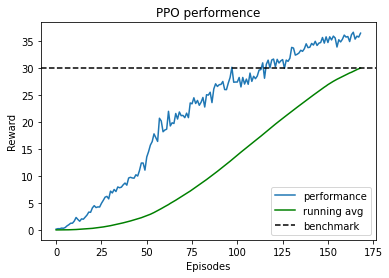

In [23]:
all_scores_for_avg = [0]*100 + all_scores
running_avg = [np.mean(all_scores_for_avg[i-100:i]) for i in range(len(all_scores_for_avg))]


fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(all_scores)), all_scores, label='performance')
plt.plot(np.arange(len(all_scores)), running_avg[100:], label='running avg', c='green')

plt.title('PPO performence')
plt.ylabel('Reward')
plt.axhline(y=BENCHMARK, color='black', linestyle="--", label='benchmark')
plt.xlabel('Episodes')
plt.legend()
plt.show()